In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
file_path = "/media/lars/F77E-7D07/"

/home/lars/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
unique_pairs = pd.read_csv(file_path + "unique_pairs.csv")

In [3]:
unique_pairs[(unique_pairs["title_1"] == "Portal") & (unique_pairs["title_2"] == "Portal 2")]

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,app_1_recommended,app_2_recommended,app_1_positive,app_2_positive,pmi,common_ratio
64060,400,Portal,620,Portal 2,7355.0,7519.0,5798.0,19904.0,5530.0,19524.0,-0.01417,0.226333


In [4]:
unique_pairs.sort_values("pmi")

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,app_1_recommended,app_2_recommended,app_1_positive,app_2_positive,pmi,common_ratio
4600,253710,theHunter Classic,1517290,Battlefield™ 2042,10.0,122.0,2259.0,13025.0,840.0,4287.0,-4.333949,0.007919
322,55100,Homefront,1517290,Battlefield™ 2042,16.0,120.0,2121.0,13027.0,1078.0,4289.0,-3.334056,0.007860
18641,271590,Grand Theft Auto V,285190,Warhammer 40000: Dawn of War III,24.0,147.0,26146.0,1663.0,16430.0,593.0,-3.273531,0.005258
15223,291480,Warface,1361210,Warhammer 40000: Darktide,27.0,143.0,3922.0,9377.0,2123.0,5316.0,-3.164535,0.010638
18974,271590,Grand Theft Auto V,1665460,eFootball™ 2024,23.0,169.0,26124.0,954.0,16408.0,125.0,-3.155669,0.006203
...,...,...,...,...,...,...,...,...,...,...,...,...
18554,271590,Grand Theft Auto V,1118200,People Playground,720.0,854.0,25439.0,7873.0,15723.0,7743.0,0.194670,0.024996
73167,25000,Overgrowth,1118200,People Playground,120.0,133.0,1207.0,8594.0,831.0,8464.0,0.199997,0.013388
18549,271590,Grand Theft Auto V,1677740,Stumble Guys,118.0,157.0,26136.0,1389.0,16420.0,1045.0,0.204644,0.005672
11761,386180,Crossout,508440,Totally Accurate Battle Simulator,97.0,117.0,2892.0,4981.0,1724.0,4837.0,0.209228,0.014643


In [5]:
minimum = 0
unique_pairs = unique_pairs[unique_pairs["common_recommended"] >= minimum]
len(unique_pairs)

127519

In [14]:
""" # Define sigmoid function for smooth transition
def compute_label(pmi, k=3):
        return 1 / (1 + np.exp(-k * (pmi + 12)))  # Smooth transition

# Apply the function
unique_pairs["label"] = unique_pairs["pmi"].apply(lambda p: compute_label(p, k=1.0))
"""

#unique_pairs["label"] = np.minimum(np.exp(1/4 * (unique_pairs["pmi"] + 0)), 1)

unique_pairs["label"] = unique_pairs["pmi"] >= -0.1

#unique_pairs["label"] = np.minimum(np.maximum(0.25 * (unique_pairs["pmi"] + 5), 0), 1)

In [15]:
unique_pairs = unique_pairs.reset_index(drop=True)

In [16]:
len(unique_pairs[unique_pairs["label"] >= 0.5]) / len(unique_pairs)

0.07511821767736572

In [17]:
# Count occurrences of "True" label for each app_id_1 and app_id_2
true_counts = pd.concat([
    unique_pairs.loc[unique_pairs["label"] > 0.5, "app_id_1"],
    unique_pairs.loc[unique_pairs["label"] > 0.5, "app_id_2"]
]).value_counts()

# Get app IDs that appear in at least 'n' rows where label is True
valid_apps = set(true_counts[true_counts >= 1].index)

# Filter the DataFrame to keep only rows where either app_id_1 or app_id_2 is in valid_apps
filtered_df = unique_pairs[
    unique_pairs["app_id_1"].isin(valid_apps) & unique_pairs["app_id_2"].isin(valid_apps)
]

In [18]:
print(len(valid_apps), len(filtered_df))

1090 108695


In [19]:
unique_pairs = filtered_df

In [20]:
games = pd.concat([
    unique_pairs[['app_id_1', 'title_1']].rename(columns={'app_id_1': 'app_id', 'title_1': 'title'}),
    unique_pairs[['app_id_2', 'title_2']].rename(columns={'app_id_2': 'app_id', 'title_2': 'title'})
])

# Drop duplicates to get unique games
games = games.drop_duplicates().reset_index(drop=True)

games


,app_id,title
0,113020,Monaco: What's Yours Is Mine
1,250180,METAL SLUG 3
2,253980,Enclave
3,282900,Hyperdimension Neptunia Re;Birth1
4,21130,LEGO® Harry Potter: Years 1-4
...,...,...
1085,1257290,Atelier Ryza 2: Lost Legends & the Secret Fair...
1086,1173790,FINAL FANTASY III
1087,2096610,Crysis 3 Remastered
1088,1999360,Placid Plastic Duck Simulator


In [21]:
unique_pairs = unique_pairs.drop(["title_1", "title_2"],axis=1)

In [22]:
le.fit(games["app_id"])
le.transform(games["app_id"])

array([ 132,  252,  263, ..., 1089, 1084, 1024], shape=(1090,))

In [23]:
games_1 = pd.DataFrame(le.transform(unique_pairs["app_id_1"]))
games_2 = pd.DataFrame(le.transform(unique_pairs["app_id_2"]))
labels = unique_pairs["label"]

In [24]:
games.to_csv(file_path + "games_network.csv", index=False)
unique_pairs.to_csv(file_path + "unique_pairs_network.csv", index=False)
games_1.to_csv(file_path + "games_1.csv", index=False)
games_2.to_csv(file_path + "games_2.csv", index=False)
labels.to_csv(file_path + "labels.csv", index=False)

In [25]:
# Define the neural network with an embedding layer
class SiameseNN(nn.Module):
    def __init__(self, num_embeddings):
        super(SiameseNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings, 64)

    def forward_one(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the embedding output
        output = x
        return output

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

    def get_distance(self, input1, input2):
        return F.pairwise_distance(input1, input2, keepdim=True)

    def get_embedding(self, x):
        return self.forward_one(x)


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=10.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        x = F.pairwise_distance(output1, output2, keepdim=True)  # Pairwise distance
        #f = torch.max((2 * label - 1) * x, (2 * label - 1) * (x - self.margin))  # Compute contrastive loss
        #loss_contrastive = torch.mean(torch.pow(torch.clamp(f, min=0.0), 2))

        loss_contrastive = torch.mean(label * torch.pow(x, 2) + (1 - label) * torch.pow(torch.clamp( self.margin - x, min=0.0), 2))

        return loss_contrastive

In [26]:
games_1 = pd.read_csv(file_path + "games_1.csv")
games_2 = pd.read_csv(file_path + "games_2.csv")
labels = pd.read_csv(file_path + "labels.csv")
games = pd.read_csv(file_path + "games_network.csv")
unique_pairs = pd.read_csv(file_path + "unique_pairs_network.csv")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read all data and send to GPU
games_1_tensor = torch.tensor(games_1.values, dtype=torch.long).to(device)
games_2_tensor = torch.tensor(games_2.values, dtype=torch.long).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1).to(device)
games_le = pd.DataFrame(le.fit_transform(games["app_id"]))
games_le_tensor = torch.tensor(games_le.values, dtype=torch.long).to(device)

# Initialize the network, loss function and optimizer
num_embeddings = len(games_le)
model = SiameseNN(num_embeddings).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

""" # Load the saved state dictionary
state_dict = torch.load("siamese_nn.pth")

# Apply the state dictionary to the model
model.load_state_dict(state_dict) """

Using device: cuda


' # Load the saved state dictionary\nstate_dict = torch.load("siamese_nn.pth")\n\n# Apply the state dictionary to the model\nmodel.load_state_dict(state_dict) '

In [27]:
import time

total_time = 2 * 60
print_time = 10
gpu_size = 20000

recommendations = unique_pairs["common_ratio"]
#recommendations = unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"]
#recommendations = unique_pairs["common_recommended"]

start_time = time.time()
print_start = time.time()
num_epochs = 0
losses = 0
last_loss = 1
length = len(unique_pairs)

while time.time() - start_time < total_time:

    if num_epochs % 50 == 0:
        sample_weights = recommendations
        sample_weights /= sample_weights.sum()
        sampled_indices = np.random.choice(unique_pairs.index, size=gpu_size, p=sample_weights)

        sampled_games_1 = games_1_tensor[sampled_indices]
        sampled_games_2 = games_2_tensor[sampled_indices]
        sampled_labels = labels_tensor[sampled_indices]

    optimizer.zero_grad()
    output_1, output_2 = model.forward(sampled_games_1, sampled_games_2)
    loss = criterion.forward(output_1, output_2, sampled_labels)
    loss.backward()
    optimizer.step()

    losses += loss.item()

    if print_time < (time.time() - print_start):
        print(f'Time elapsed: {int((time.time() - print_start))}s, {num_epochs} epochs, Percentage lost: {((last_loss - (losses / num_epochs)) / last_loss) * 100:.8f}, Loss: {losses / num_epochs:.8f}')

        last_loss = losses / num_epochs
        losses = 0
        print_start = time.time()
        torch.save(model.state_dict(), "siamese_nn.pth")
        num_epochs = 0

    num_epochs += 1

Time elapsed: 10s, 1569 epochs, Percentage lost: -665.91976386, Loss: 7.65919764
Time elapsed: 10s, 2004 epochs, Percentage lost: 34.16991775, Loss: 5.04205611
Time elapsed: 10s, 2308 epochs, Percentage lost: 8.49870458, Loss: 4.61354665
Time elapsed: 10s, 2383 epochs, Percentage lost: 2.96350792, Loss: 4.47682383
Time elapsed: 10s, 1773 epochs, Percentage lost: 1.23323341, Loss: 4.42161415
Time elapsed: 10s, 2156 epochs, Percentage lost: -0.07754880, Loss: 4.42504305
Time elapsed: 10s, 2113 epochs, Percentage lost: 0.34807077, Loss: 4.40964077
Time elapsed: 10s, 1827 epochs, Percentage lost: 0.83688503, Loss: 4.37273715
Time elapsed: 10s, 2490 epochs, Percentage lost: -0.46886621, Loss: 4.39323944
Time elapsed: 10s, 2350 epochs, Percentage lost: 0.12398961, Loss: 4.38779228
Time elapsed: 10s, 2162 epochs, Percentage lost: -0.34719487, Loss: 4.40302647


In [28]:
torch.save(model.state_dict(), "siamese_nn.pth")

In [29]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embedding(games_le_tensor)

model.train()

games["location"] = list(embeddings.cpu().detach().numpy())
locations_array = np.array(games["location"].tolist())


In [30]:
# Reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
games["location_2d"] = list(tsne.fit_transform(locations_array))

/home/lars/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128739 (\N{MOTORWAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


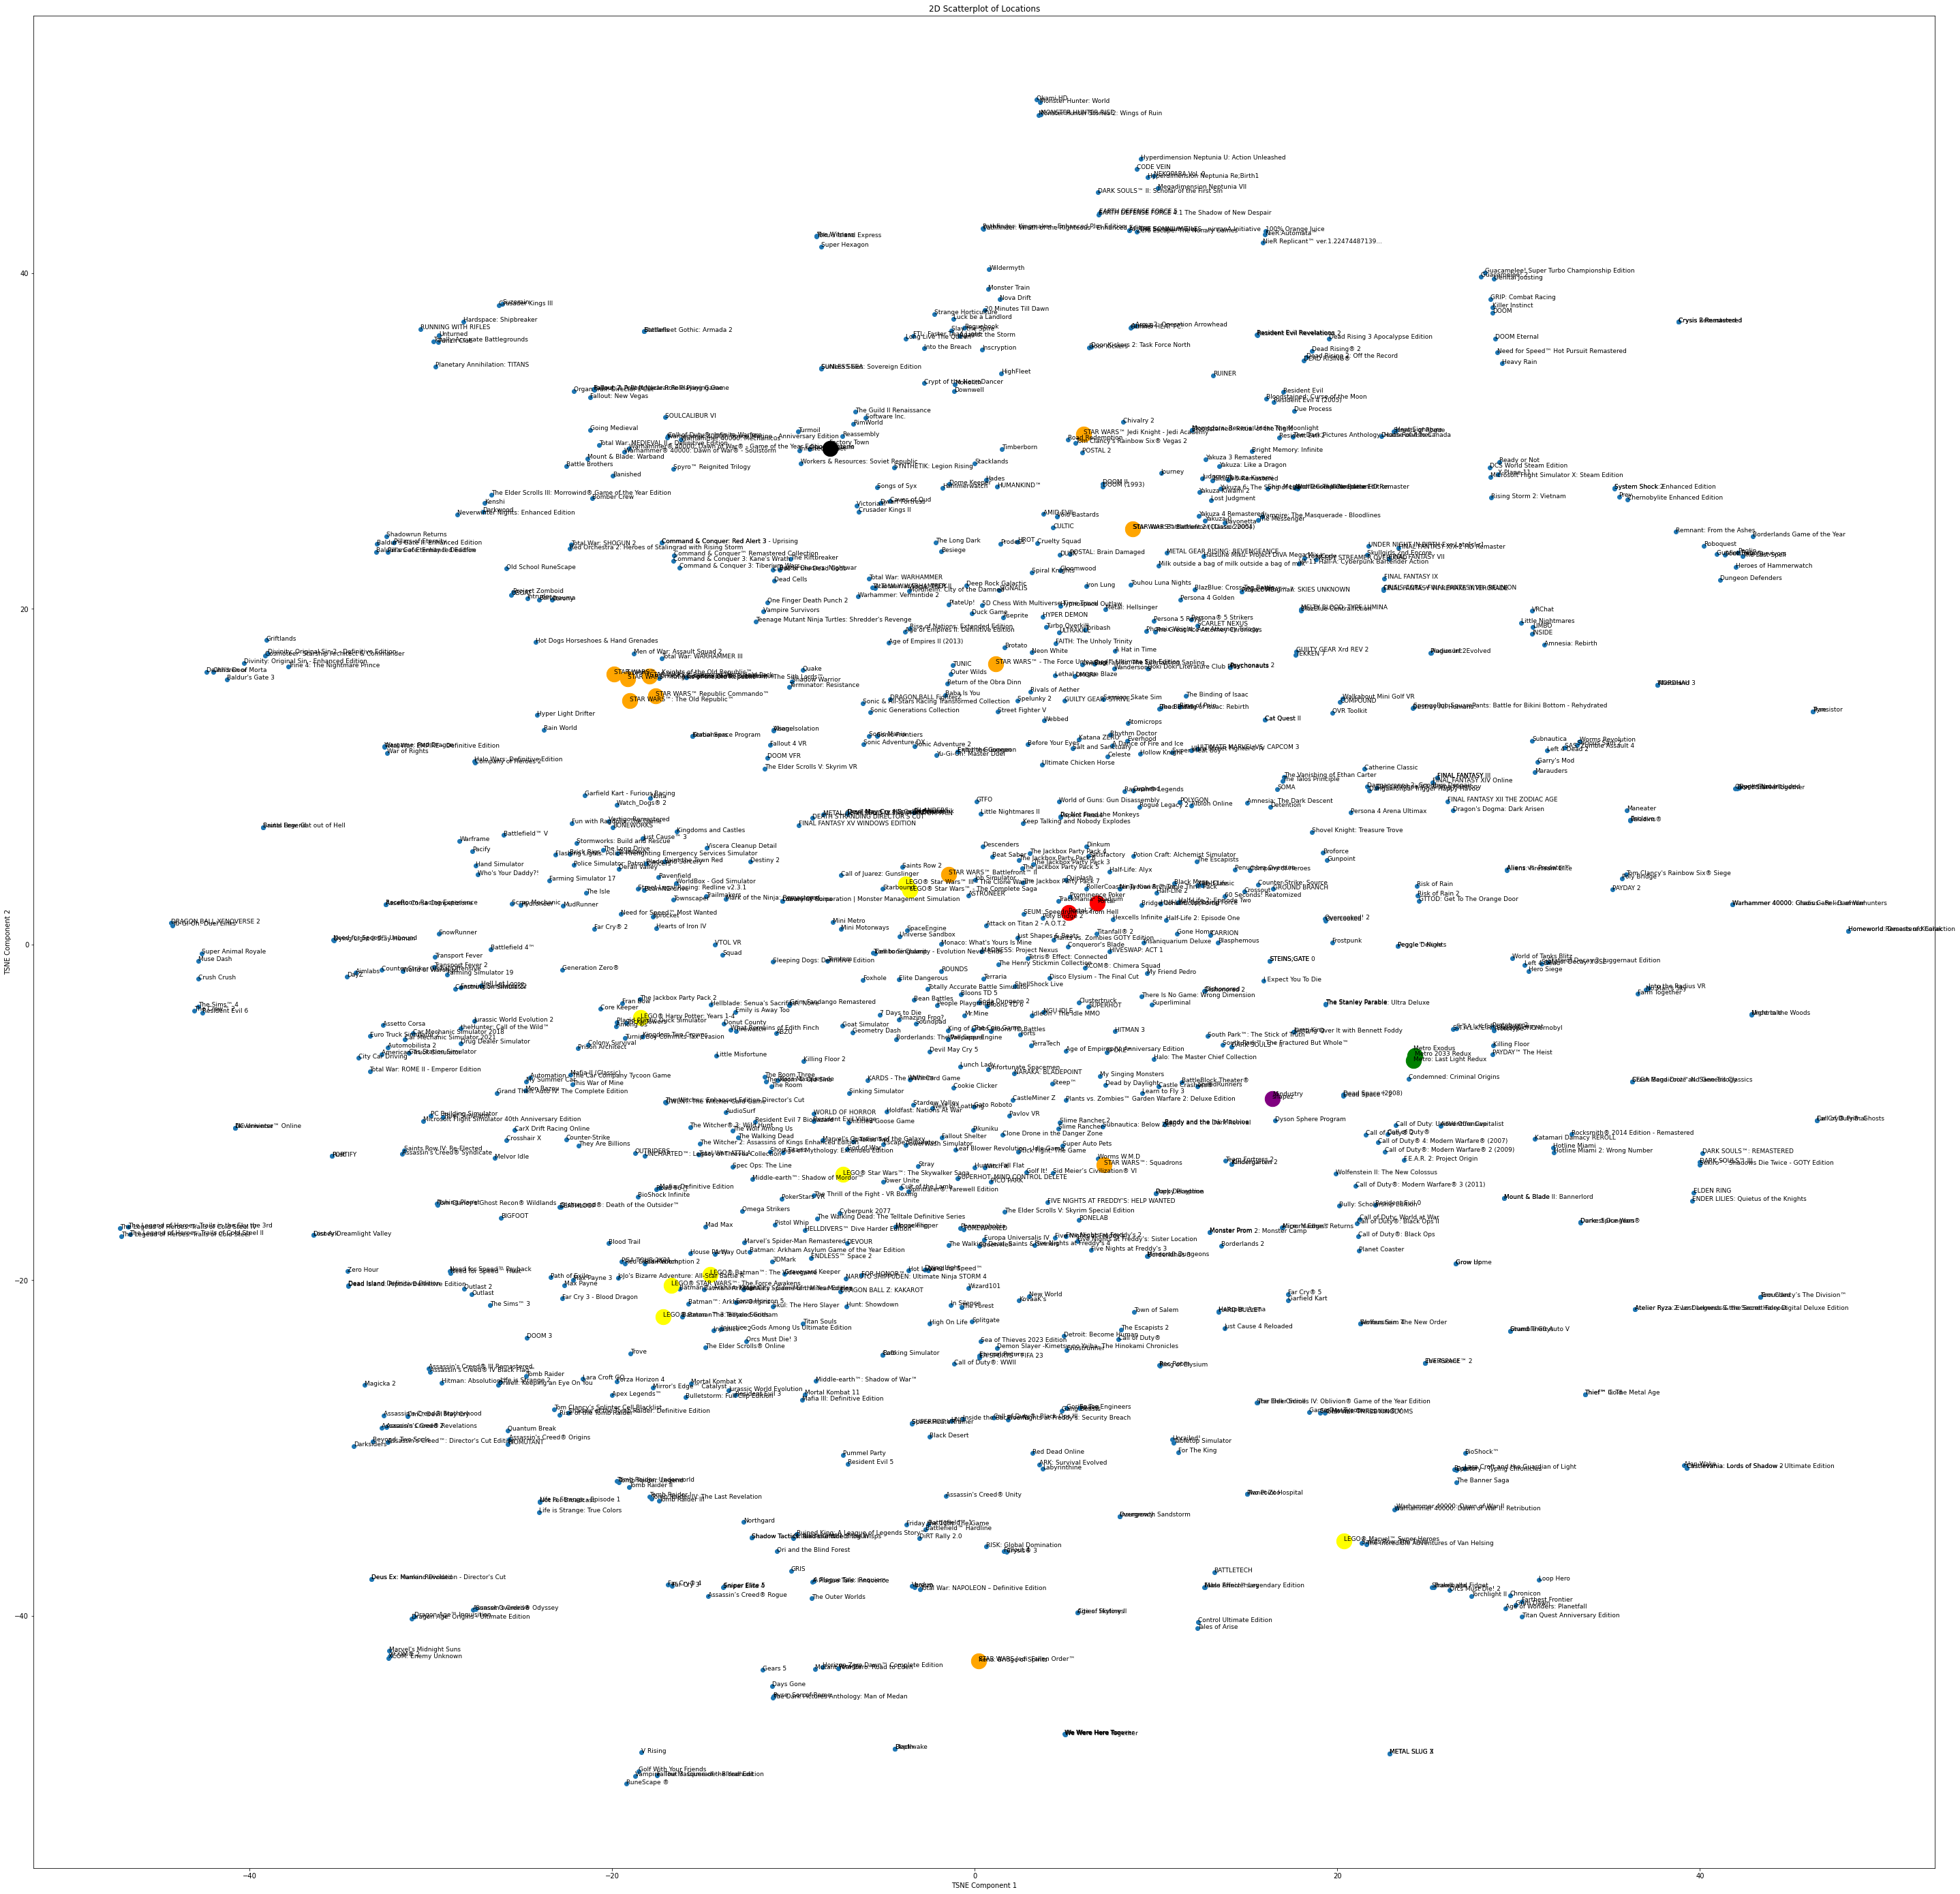

In [31]:
plt.figure(figsize=(50, 50))
plt.scatter(games["location_2d"].apply(lambda x: x[0]), games["location_2d"].apply(lambda x: x[1]))

for i, row in games.iterrows():
    plt.text(row["location_2d"][0], row["location_2d"][1], str(row["title"]), fontsize=9)


for i, row in games.iterrows():
    if str(row["title"]) == "shapez":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='black', s=500)  # Larger and black dot
    if str(row["title"]) == "Portal":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Portal 2":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Metro 2033 Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) == "Metro: Last Light Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) in list(games[games["title"].str.startswith("LEGO", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and yellow dot
    if str(row["title"]) in list(games[games["title"].str.startswith("STAR WARS", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='orange', s=500)  # Larger and orange dot

""" for i, row in games.iterrows():
    if row["app_id"] in result:
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and purple dot """

plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations")
plt.show()

In [32]:
games.to_csv("filtered_archive/games_locations.csv")

In [33]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Convert the column of lists into a 2D NumPy array
location_data = np.vstack(games["location"])

kmeans = KMeans(n_clusters=25)
kmeans.fit(location_data)

scaler = StandardScaler()
scaler.fit(location_data)
X_scaled = scaler.transform(location_data)

dbscan = DBSCAN(eps=2, min_samples=10)
clusters = dbscan.fit_predict(X_scaled)

In [34]:
games["cluster"] = kmeans.labels_
games["cluster_2"] = clusters + 1

In [35]:
games["cluster_2"].nunique()

2

/tmp/ipykernel_10978/3773276701.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rainbow", num_clusters)  # Or use "viridis", "rainbow", etc.


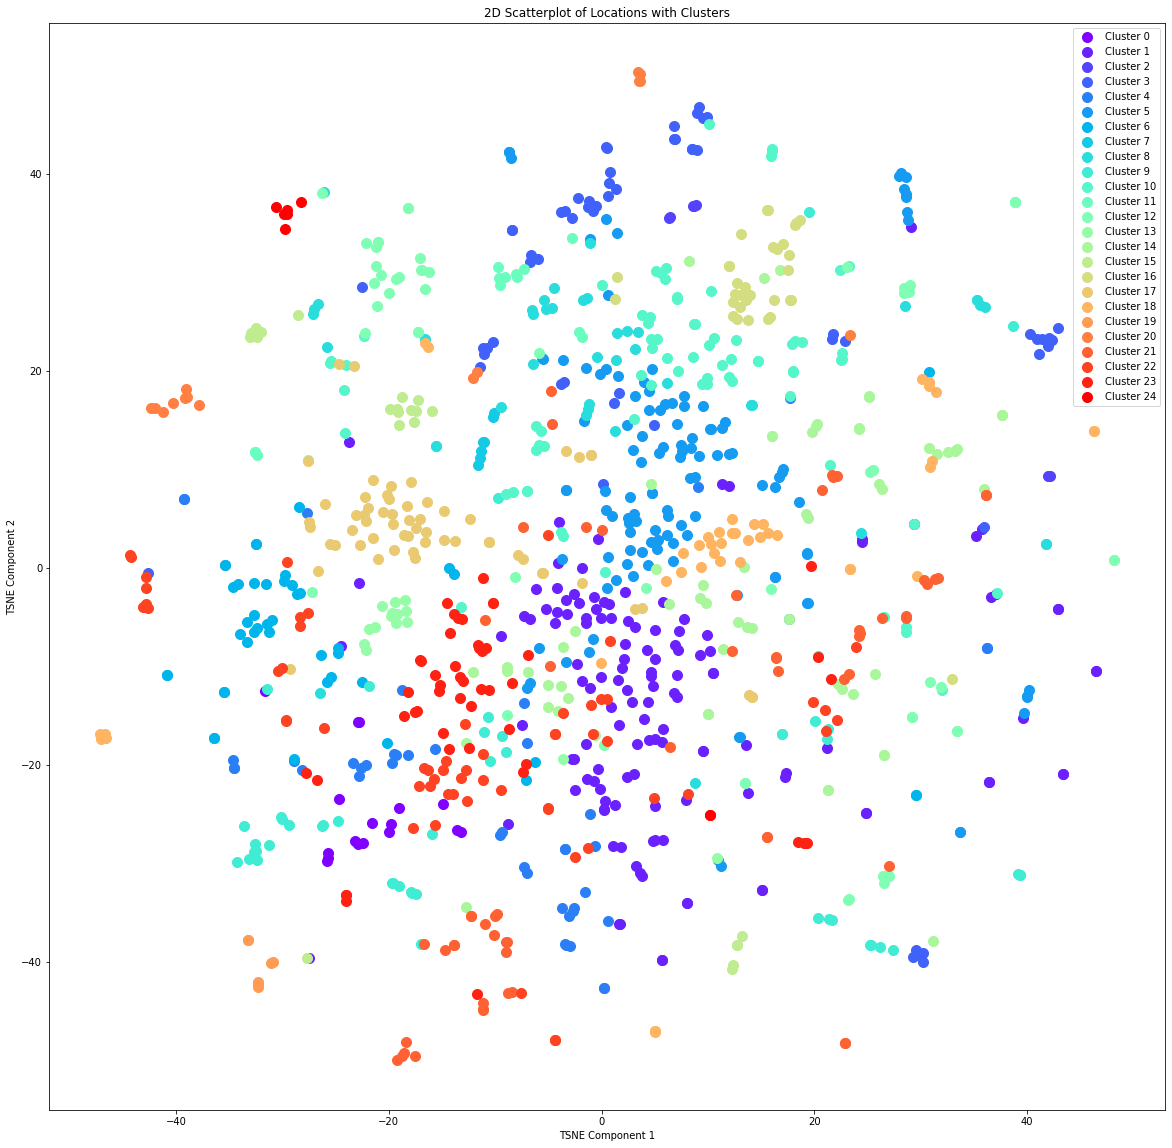

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a colormap for clusters
num_clusters = games["cluster"].nunique()
cmap = plt.cm.get_cmap("rainbow", num_clusters)  # Or use "viridis", "rainbow", etc.
colors = [cmap(i / num_clusters) for i in range(num_clusters)]


plt.figure(figsize=(20, 20))  # Adjust figure size as needed

# Scatter plot with unique colors per cluster
for cluster in range(num_clusters):
    cluster_data = games[games["cluster"] == cluster]
    plt.scatter(
        cluster_data["location_2d"].apply(lambda x: x[0]),
        cluster_data["location_2d"].apply(lambda x: x[1]),
        color=colors[cluster],
        label=f"Cluster {cluster}",
        s=100  # Adjust size as needed
    )


# Labels and title
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations with Clusters")
plt.legend()
plt.show()
